# Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

#### Импортируем необходимые для работы библиотеки 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from collections import namedtuple
import warnings

warnings.filterwarnings('ignore')

In [2]:
! pip install phik 

     |████████████████████████████████| 679 kB 1.4 MB/s eta 0:00:01


In [3]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

# 1. Изучение данных 

In [4]:
df_contract= pd.read_csv('/Users/roman/Desktop/final_provider/contract.csv')
df_personal = pd.read_csv('/Users/roman/Desktop/final_provider/personal.csv')
df_internet = pd.read_csv('/Users/roman/Desktop/final_provider/internet.csv')
df_phone = pd.read_csv('/Users/roman/Desktop/final_provider/phone.csv')

In [5]:
def data_info(df):
    display(df.head())
    display(df.info())
    display('Количество дубликатов строк', df.duplicated().sum())
    display('Количество пропусков в данных по столбцам', df.isna().sum())
    display('Оценка непрерывных данных', df.describe())
    display('Название столбцов', df.columns)
    display('Количесвто столбцов', df.shape[1])
    display('Количество строк', df.shape[0])

### Файл df_contract - информация о договорах c Клиентами

In [6]:
data_info(df_contract) 

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

'Количество дубликатов строк'

0

'Количество пропусков в данных по столбцам'

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

'Оценка непрерывных данных'

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


'Название столбцов'

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

'Количесвто столбцов'

8

'Количество строк'

7043

In [7]:
df_contract['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

In [8]:
df_contract['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [9]:
df_contract['PaperlessBilling'].value_counts()

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

### Что необходимо сделать для дальнейшей работы:
   - необходимо переименовать название столбцов используя змениный стиль и заглавные буквы в названии
   - необходимо поменять тип данных в дате начала / конца контракта 
   - необходимо перевести тип данных TotalCharges в float64 
   - также перевести данные о дате начале и конца договора в формат date time 
   - для определения дюрации необходимо вычесть из даты начала договора, дату его окончания

### Файл df_personal - информация о клиентах

In [10]:
data_info(df_personal) 

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

'Количество дубликатов строк'

0

'Количество пропусков в данных по столбцам'

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

'Оценка непрерывных данных'

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


'Название столбцов'

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

'Количесвто столбцов'

5

'Количество строк'

7043

In [11]:
df_personal['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

In [12]:
df_personal['Partner'].value_counts()

No     3641
Yes    3402
Name: Partner, dtype: int64

In [13]:
df_personal['Dependents'].value_counts()

No     4933
Yes    2110
Name: Dependents, dtype: int64

#### Вывод: 
   - данные корректны 
   - необходимо поменять название столбцов
   
   - в дальнейшем необходимо провести кодировку категориальных признаков Partner, Dependents, Gender

### Файл df_internet - информация об интернет услугах

In [14]:
data_info(df_internet) 

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

'Количество дубликатов строк'

0

'Количество пропусков в данных по столбцам'

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

'Оценка непрерывных данных'

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,4800-CZMPC,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


'Название столбцов'

Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

'Количесвто столбцов'

8

'Количество строк'

5517

In [15]:
df_internet['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

In [16]:
df_internet['OnlineSecurity'].value_counts()

No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

### Вывод:
   - необходимо поменять тип данных
   - необходимо провести кодировку признаков 

### Файл df_phone - информация об услугах телефонии 

In [17]:
data_info(df_phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

'Количество дубликатов строк'

0

'Количество пропусков в данных по столбцам'

customerID       0
MultipleLines    0
dtype: int64

'Оценка непрерывных данных'

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,9397-TZSHA,No
freq,1,3390


'Название столбцов'

Index(['customerID', 'MultipleLines'], dtype='object')

'Количесвто столбцов'

2

'Количество строк'

6361

In [18]:
df_phone['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

### Вывод:
   - необходимо поменять тип данных и провести кодировку булевых значений 

# 2. Предобработка данных 

### df_contract 

In [19]:
df_contract = df_contract.rename(columns = {'customerID': 'customer_id', 'BeginDate':'begin_date', 
                                            'EndDate':'end_date', 'PaperlessBilling':'paperless_billing',
                                           'PaymentMethod':'payment_method', 'MonthlyCharges':'monthly_charges',
                                            'TotalCharges':'total_charges', 'Type':'type' })
df_contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [20]:
df_contract['total_charges'] = pd.to_numeric(df_contract['total_charges'], errors ='coerce') 


In [21]:
df_contract.isna().mean()

customer_id          0.000000
begin_date           0.000000
end_date             0.000000
type                 0.000000
paperless_billing    0.000000
payment_method       0.000000
monthly_charges      0.000000
total_charges        0.001562
dtype: float64

In [22]:
df_contract['total_charges'] = df_contract['total_charges'].fillna(18.25)
display(df_contract[df_contract['total_charges'] == 'NaN'].shape[0])

0

#### В результате преобразования Total charges, в данных появились пропуски (Nan), которые мы заменили на нулевые значения, что в данном случае будет корректным решением

In [23]:
df_contract.isna().mean()

customer_id          0.0
begin_date           0.0
end_date             0.0
type                 0.0
paperless_billing    0.0
payment_method       0.0
monthly_charges      0.0
total_charges        0.0
dtype: float64

In [24]:
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'], format='%Y-%m-%d')


#### Поскольку в данных End date есть NO, что означает договор был актуален на дату выгрузки данных, поэтому эти поля можно заменить датой выгрузки  1 февраля 2020, предварительно проверив если кто то из клиентов расторг договор в эту дату

In [25]:
df_contract['end_date'].isin(['2020-02-01']).value_counts()

False    7043
Name: end_date, dtype: int64

In [26]:
df_contract['end_date'].isin(['No']).value_counts()

True     5174
False    1869
Name: end_date, dtype: int64

In [27]:
df_contract['end_date'] = df_contract['end_date'].replace(['No'], ['2020-02-01'])
print(df_contract[df_contract['end_date'] == 'No'].shape[0]) 

0


In [28]:
df_contract['end_date'].isin(['2020-02-01']).value_counts()

True     5174
False    1869
Name: end_date, dtype: int64

In [29]:
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'], format='%Y-%m-%d')

In [30]:
df_contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


In [31]:
df_contract['duration'] = (df_contract['end_date'] - df_contract['begin_date']).dt.days

In [32]:
df_contract.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,61


### df_personal

In [33]:
df_personal = df_personal.rename(columns={'customerID':'customer_id', 'gender':'gender', 
                                 'SeniorCitizen':'senior_citizen', 'Partner':'partner', 'Dependents':'dependents'})
df_personal.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [34]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [35]:
df_personal.head()

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


### df_internet 

In [36]:
df_internet = df_internet.rename(columns={'customerID':'customer_id', 'InternetService':'internet_service' ,
                                          'OnlineSecurity': 'online_security', 'OnlineBackup':'online_backup',
       'DeviceProtection':'device_protection', 'TechSupport':'tech_support', 'StreamingTV':'streaming_tv',
                                          'StreamingMovies':'streaming_movies'})

In [37]:
df_internet.head()

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


### df_phone 

In [38]:
df_phone = df_phone.rename(columns={'customerID':'customer_id', 'MultipleLines':'multiple_lines'})

In [39]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [40]:
df_phone.head()

,customer_id,multiple_lines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


#### Общий вывод по предобработке данных:
   - были изменены названия столбцов 
   - был изменен тип данных в Total charges на float32, проявившиеся NaN значения были заменены на ноль, видимо это информация о клиентах которые только недавно пришли в Компанию
   - были изменен тип данных на date time в столбцах, где указаны даты начала и окончание договора с клиентом 
   - также отстувтсвие информации по окончанию договора был заменен на даты выгрузки данный 1 февраля 2020
   - по всей видимости это действующие нерасторгнутые договоры с клиентами и данная информация в дальнейшем будет ялвяться целевым признаком для нашей работы 
   - добавлена колонка информации по дюрации денежных потоков от клиентов

### План по выполнению проекта:

    1. Изучение данных: Импортирование данных, просмотр файлов, изучение полученной информации. Проверка данных на    
        корректность типа и значений согласно описанию
    2. Предобработка данных: поиск аномалий, пропусков, дубликатов, проведение мероприятий по их устранению.              
    3. Определяем целевой признак - дата окончания договора с Компанией  
    4. Обрабатываем данные в сводной таблице. 
       Определяем целевой признак - дата окончания договора с Компанией 
    5. Объединение данных в одну сводную таблицу по индексу Customer_ID. Проверям данные на наличие пропусков.
    6. Проводим исследовательский анализ данных. Находим зависимость между полученными данными и фактом ухода           
       Клиентов из Компании
    7. Проверка мультиколлинеарности признаков с таргетом
    8. Feature Selection - отбор признаков для обучения моделей 
    9. Подбор гиперпараметров
    10. Выбор лучшей модели (по метрики на кроссвалидации)
    11. Определение итоговой метрики на тесте
    12. Финальный отчет о выполнении задания  
    

### Объединение таблиц в одну сводную по индексу Customer_ID, изучение данных, заполнение пропусков.  Добавляем целевой признак 

In [41]:
df_total = df_contract.merge(df_personal, how='left', on='customer_id')\
  .merge(df_internet, how='left', on='customer_id') \
    .merge(df_phone, how='left', on='customer_id') 

In [42]:
data_info(df_total)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,duration,gender,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,31,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,1036,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,61,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,1371,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,61,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   duration           7043 non-null   int64         
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  internet_service   5517 non-null   object        
 14  online_s

None

'Количество дубликатов строк'

0

'Количество пропусков в данных по столбцам'

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
duration                0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

'Оценка непрерывных данных'

,monthly_charges,total_charges,duration,senior_citizen
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.762807,985.996166,0.162147
std,30.090047,2266.765914,747.587844,0.368612
min,18.250000,18.250000,0.000000,0.000000
25%,35.500000,398.550000,273.000000,0.000000
50%,70.350000,1394.550000,883.000000,0.000000
75%,89.850000,3786.600000,1676.000000,0.000000
max,118.750000,8684.800000,2191.000000,1.000000


'Название столбцов'

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'duration',
       'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')

'Количесвто столбцов'

21

'Количество строк'

7043

#### Появившиеся в сводной таблице пропуски в данных о подключенных интернет улсугах заменяем на 'No'

In [43]:
for columns in ('internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support',
               'streaming_tv', 'streaming_movies', 'multiple_lines'):
    df_total[columns] = df_total[columns].fillna('No')


#### Добавялем новый столбец - целевой признак - Status с информацией о текущем статусе клиента - 1 - клиент ушел, 0 - клиент активен

In [44]:
df_total['status'] = (df_total['end_date'] != '2020-02-01').astype(int)

In [45]:
df_total['status'].value_counts()

0    5174
1    1869
Name: status, dtype: int64

In [46]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   duration           7043 non-null   int64         
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  internet_service   7043 non-null   object        
 14  online_s

#### Вывод:
    В реузултьтате преобразований мы получили одну сводную таблицу по Customer_ID, в которой собраны все данные по     услугам, которые Компания предоставляет клиентам, также все денежные потоки, которые компания получает от клиентов в рамках действующих договоров. В таблицу добавлен целевой признак - текущий статус Клиента (1 - Клиент ушел из компании, 0     - клиент активен). Можно двигаться дальше - исследовать зависимомости между данными и фактом ухода Клиентов из     Компании.   

# 3. Исследовательский анализ данных

In [47]:
df_total.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,duration,gender,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,status
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,31,Female,...,No,DSL,No,Yes,No,No,No,No,No,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,1036,Male,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,61,Male,...,No,DSL,Yes,Yes,No,No,No,No,No,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,1371,Male,...,No,DSL,Yes,No,Yes,Yes,No,No,No,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,61,Female,...,No,Fiber optic,No,No,No,No,No,No,No,1


In [48]:
numeric_data = ['monthly_charges', 'total_charges', 'duration']
categorial_data = [
    'customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 
       'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'
]


Исследуем распределение категориальных данных, предварительно удаляя лишние колонки с информацией Id клиента, дата и начало действия договора - эти данные для нас не существенны 

In [49]:
del categorial_data[0:3]
categorial_data

['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

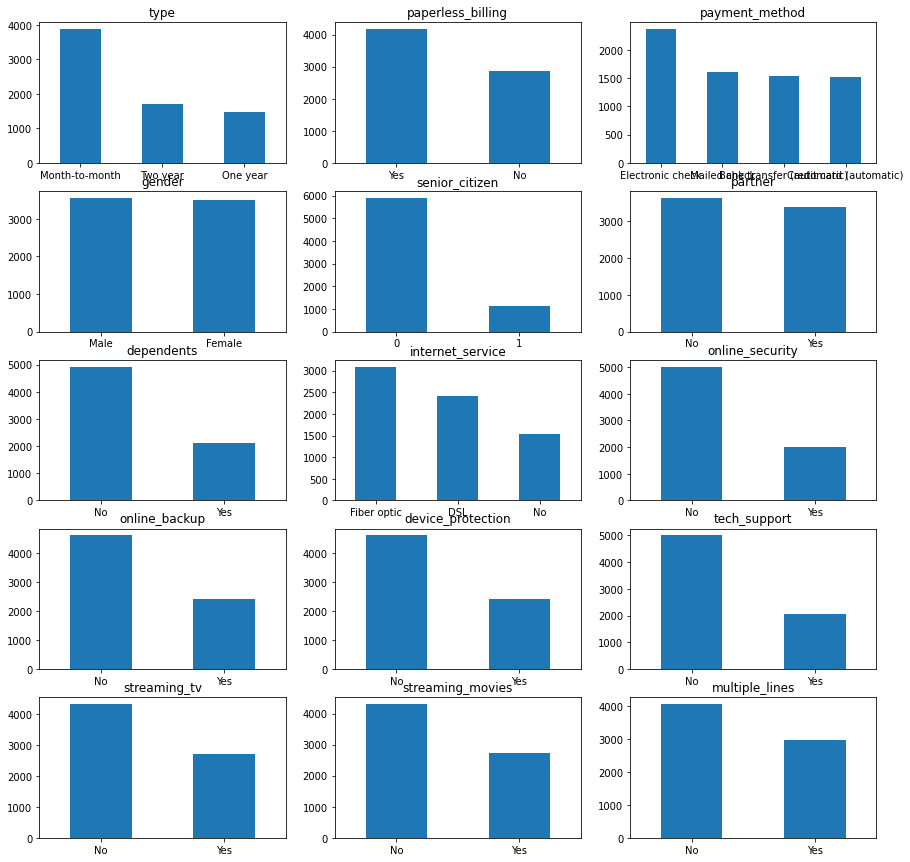

In [50]:
cols = 3
rows = 5

plt.figure(figsize=(15, 15))

for idx, column in enumerate(categorial_data):
    ax = plt.subplot(rows, cols, idx + 1)
    
    df_total[column].value_counts().plot(
        kind='bar', 
        title=column, 
        ax=ax,
        rot=0)
        
plt.show()

Распределение непрерывных переменных и диаграмма размаха 

In [51]:
def plot_num_data(df):
    cols = 3
    rows = 2

    plt.figure(figsize=(15, 10))

    chrt = 0
    for column in numeric_data:
        chrt += 1 
    
        plt.subplot(rows, cols, chrt)
        plt.hist(df[column])
        plt.title(column)
    
    for column in numeric_data:
        chrt += 1 
    
        plt.subplot(rows, cols, chrt)
        plt.boxplot(df[column])
        plt.title(column)
        
    plt.show()


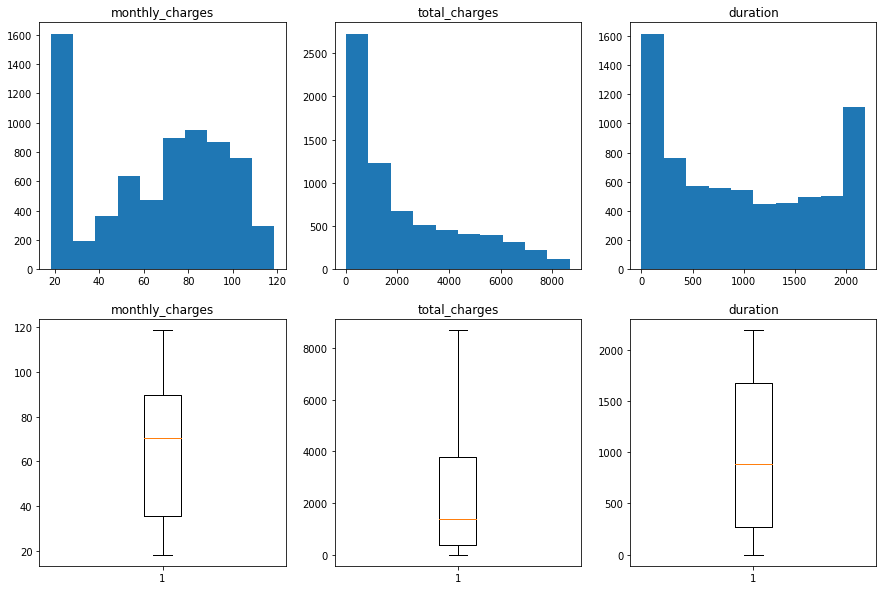

In [52]:
plot_num_data(df_total[numeric_data])

In [53]:
display(df_total[numeric_data].describe())

,monthly_charges,total_charges,duration
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.762807,985.996166
std,30.090047,2266.765914,747.587844
min,18.250000,18.250000,0.000000
25%,35.500000,398.550000,273.000000
50%,70.350000,1394.550000,883.000000
75%,89.850000,3786.600000,1676.000000
max,118.750000,8684.800000,2191.000000


Вывод: 
- Данные распределены в примерно одинаковой пропорции по гендерному признаку, самая популярная форма оплаты является электронный платеж, наиболее часто используемая регулярность оплаты - раз в месяц. Количественные данные monthly_charges, total_charges имеют выбросы в районе нуля, что говорит о том, что наибольшие днежные потоки приходят от клиентов в первые дни месяцы их обслуживания в компании. Также интересны пиковые значения в начале и конце распределения данных duration - это говорит что многие клиенты уходят после нескольких месяцев осблуживания, но также существенное количество остаются на конец исследуемого нами периода. Значительное большинство клиентов не являются пенисионерами. Большинство услуг интернет телефонии у клиентов не подключены

Исследование зависимости категориальных значений и целевого признака  

In [54]:
df_total['status'].mean()

0.2653698707936959

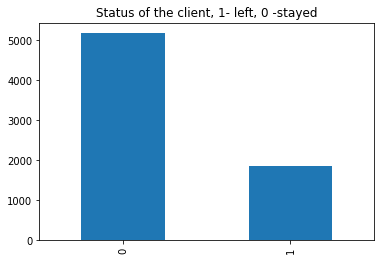

In [55]:
df_total['status'].value_counts().plot(kind='bar')
plt.title('Status of the client, 1- left, 0 -stayed')
plt.show()

In [56]:
df_total['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

In [57]:
df_total.groupby('gender')['status'].agg(['mean','count'])

,mean,count
gender,,
Female,0.269209,3488
Male,0.261603,3555


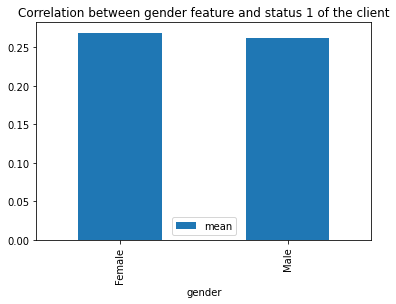

In [58]:
df_total.groupby('gender')['status'].agg(['mean']).plot(kind='bar')
plt.title('Correlation between gender feature and status 1 of the client')
plt.show()

In [59]:
df_total.groupby('type')['status'].agg(['mean','count'])

,mean,count
type,,
Month-to-month,0.427097,3875
One year,0.112695,1473
Two year,0.028319,1695


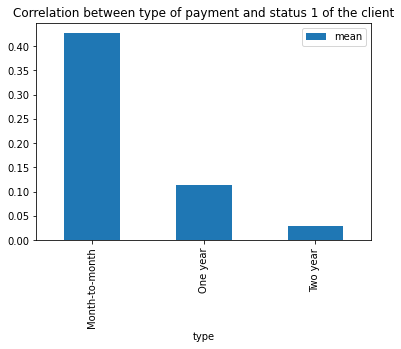

In [60]:
df_total.groupby('type')['status'].agg(['mean']).plot(kind='bar')
plt.title('Correlation between type of payment and status 1 of the client')
plt.show()

In [61]:
df_total.groupby('paperless_billing')['status'].agg(['mean','count'])

,mean,count
paperless_billing,,
No,0.163301,2872
Yes,0.335651,4171


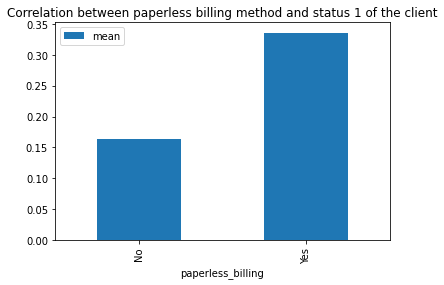

In [62]:
df_total.groupby('paperless_billing')['status'].agg(['mean']).plot(kind='bar')
plt.title('Correlation between paperless billing method and status 1 of the client')
plt.show()

In [63]:
df_total.groupby('payment_method')['status'].agg(['mean','count'])

,mean,count
payment_method,,
Bank transfer (automatic),0.167098,1544
Credit card (automatic),0.152431,1522
Electronic check,0.452854,2365
Mailed check,0.191067,1612


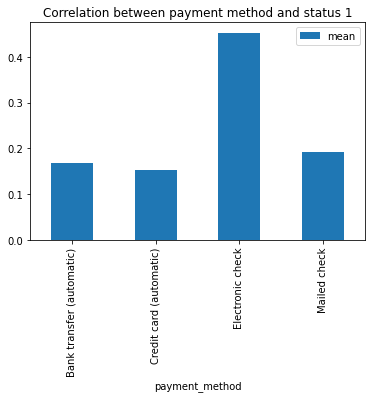

In [64]:
df_total.groupby('payment_method')['status'].agg(['mean']).plot(kind='bar')
plt.title('Correlation between payment method and status 1')
plt.show()

In [65]:
df_total.groupby('dependents')['status'].agg(['mean','count'])

,mean,count
dependents,,
No,0.312791,4933
Yes,0.154502,2110


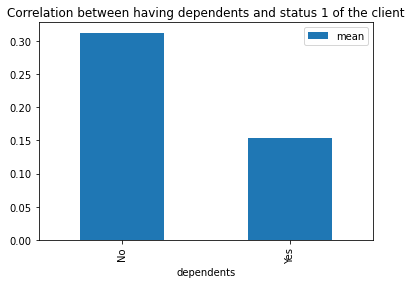

In [66]:
df_total.groupby('dependents')['status'].agg(['mean']).plot(kind='bar')
plt.title('Correlation between having dependents and status 1 of the client')
plt.show()

Исследуем зависимости непрерывных значений и целевого признака - для этого проведем сегментацию количественных данных на 5 групп по возрастанию сумм значений и создадим вспомогательные столбцы для проведения сводного анализа

In [67]:
df_total['duration_group'] = pd.qcut(df_total['duration'],5)

In [68]:
df_total.groupby('duration_group')['status'].agg(['mean','count'])

,mean,count
duration_group,,
"(-0.001, 184.0]",0.529372,1481
"(184.0, 609.0]",0.344054,1337
"(609.0, 1217.0]",0.226695,1416
"(1217.0, 1826.0]",0.150499,1402
"(1826.0, 2191.0]",0.066098,1407


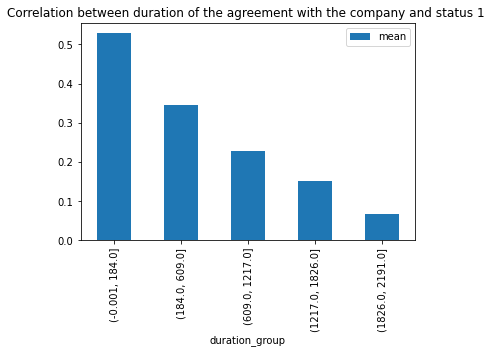

In [69]:
df_total.groupby('duration_group')['status'].agg(['mean']).plot(kind='bar')
plt.title('Correlation between duration of the agreement with the company and status 1 ')
plt.show()

In [70]:
df_total['monthly_charges_group'] = pd.qcut(df_total['monthly_charges'],5)

In [71]:
df_total.groupby('monthly_charges_group')['status'].agg(['mean','count'])

,mean,count
monthly_charges_group,,
"(18.249, 25.05]",0.091549,1420
"(25.05, 58.83]",0.249821,1397
"(58.83, 79.1]",0.297661,1411
"(79.1, 94.25]",0.361052,1407
"(94.25, 118.75]",0.328125,1408


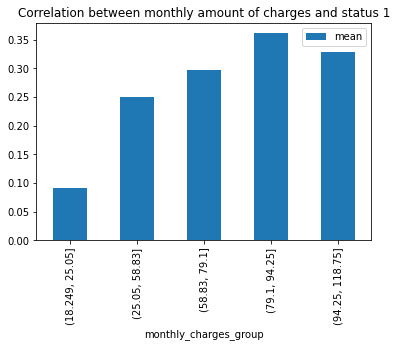

In [72]:
df_total.groupby('monthly_charges_group')['status'].agg(['mean']).plot(kind='bar')
plt.title('Correlation between monthly amount of charges and status 1')
plt.show()

In [73]:
df_total['total_charges_group'] = pd.qcut(df_total['total_charges'],5)

In [74]:
df_total.groupby('total_charges_group')['status'].agg(['mean','count'])

,mean,count
total_charges_group,,
"(18.249, 265.32]",0.457771,1409
"(265.32, 939.78]",0.289062,1408
"(939.78, 2043.71]",0.208659,1409
"(2043.71, 4471.44]",0.230114,1408
"(4471.44, 8684.8]",0.141235,1409


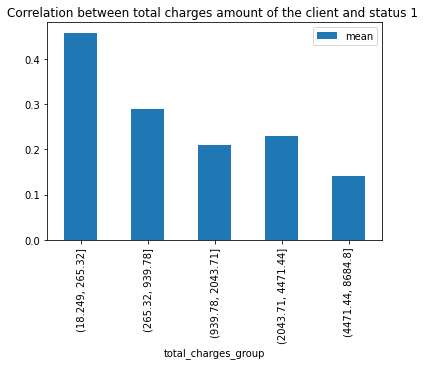

In [75]:
df_total.groupby('total_charges_group')['status'].agg(['mean']).plot(kind='bar')
plt.title('Correlation between total charges amount of the client and status 1 ')
plt.show()

Изучим корреляцию между данными:

In [76]:
df_total.corr()['status'].sort_values(ascending=False)

status             1.000000
monthly_charges    0.193356
senior_citizen     0.150889
total_charges     -0.198334
duration          -0.352673
Name: status, dtype: float64

Предположения по итогам исследования:

- Чем выше оплата в месяц, тем выше вероятность, что клиент уйдет 
- Достижение порогового значения месячной оплаты возможно как в первые месяцы так и в последующие, но более чувствительными  к росту месячной оплаты       являются клиенты в первый год обслуживания  
- Наблюдается резкий отток клиентов после попадания месячного платежа в диапазон 60 - 80 единиц
- Чем дольше клиент в компании, тем вероятность ухода ниже при условии сохранения размера месячного платежа

Общий вывод по исследованию признаков:
- Компанию покинуло 26% клиентов. Из низ примерно в равной пропорции мужчины и женщины, клиенты использовали в большинстве своем по месячную оплату услуг, а также электронную форму оплаты. То есть в основном уходили те кто использует помесячную форму оплаты.
- Главный вывод - это факт ухода из компании большого количества клиентов в первый год обслуживания в случае роста размера месячного платежа. Также интересна обратная тенденция на рост общей суммы платежей и увеличение срока действия договора с компанией. Видимо уходят те, кого не устраивает размер месячного платежа по итогам года, а те кого размер платежа утстраивает либо он ниже предельного значения остаются с ней надолго.
- Возможно имеет смысл обратить внимание на пороговое значение месячного тарифа уровня значения третьего квантиля. Достижение данного уровня является сигналом для лояльных действий со стороны Компании по отношению к Клиенту особенно после первого года обслуживания
  

Проверяем данные на мультиколлинеарность

In [77]:
 df_total[numeric_data].corr() 

,monthly_charges,total_charges,duration
monthly_charges,1.000000,0.651172,0.247754
total_charges,0.651172,1.000000,0.826103
duration,0.247754,0.826103,1.000000


Наблюдаем линейную зависимость 0.82 между total_charges и duration - что выглядит логичным, чем дольше клиент в компании тем больше он платит. Данная зависимость нам будет мешать, поэтому удалим столбец total charges, также удалим вспомогательные группы количественных данных

In [78]:
df_total = df_total.drop(columns= ['total_charges','total_charges_group',
                                   'monthly_charges_group', 'duration_group'], axis=1) 


In [79]:
phik_overview = df_total.phik_matrix()

interval columns not set, guessing: ['monthly_charges', 'duration', 'senior_citizen', 'status']


In [80]:
phik_overview

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,duration,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,status
customer_id,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
begin_date,1.0,1.000000,0.584146,0.766249,0.081447,0.456389,0.421886,0.995271,0.011268,0.050862,...,0.208564,0.192197,0.403560,0.445583,0.456002,0.399506,0.359784,0.371863,0.428109,0.495211
end_date,1.0,0.584146,1.000000,0.357462,0.156832,0.212169,0.319733,0.408477,0.000000,0.123124,...,0.133425,0.288479,0.139392,0.068364,0.051336,0.134227,0.050373,0.047014,0.034949,1.000000
type,1.0,0.766249,0.357462,1.000000,0.106860,0.277462,0.388444,0.664660,0.000000,0.086231,...,0.147680,0.505187,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608,0.065498,0.251639
paperless_billing,1.0,0.081447,0.156832,0.106860,1.000000,0.370495,0.467812,0.000000,0.000000,0.242133,...,0.172593,0.231438,0.000000,0.196443,0.160796,0.055929,0.343524,0.325551,0.252972,0.295754
payment_method,1.0,0.456389,0.212169,0.277462,0.370495,1.000000,0.399526,0.375115,0.000000,0.292725,...,0.224903,0.323886,0.262911,0.282475,0.306866,0.272101,0.377209,0.378907,0.339313,0.449125
monthly_charges,1.0,0.421886,0.319733,0.388444,0.467812,0.399526,1.000000,0.411191,0.008175,0.304985,...,0.184366,0.919002,0.551621,0.629541,0.667481,0.576525,0.835340,0.833307,0.675883,0.360050
duration,1.0,0.995271,0.408477,0.664660,0.000000,0.375115,0.411191,1.000000,0.000000,0.028663,...,0.212209,0.019357,0.424786,0.465284,0.465931,0.422111,0.359254,0.371121,0.433522,0.474001
gender,1.0,0.011268,0.000000,0.000000,0.000000,0.000000,0.008175,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.018397,0.009882,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
senior_citizen,1.0,0.050862,0.123124,0.086231,0.242133,0.292725,0.304985,0.028663,0.000000,1.000000,...,0.324576,0.160702,0.057028,0.102065,0.090686,0.092565,0.163120,0.186141,0.221313,0.233432


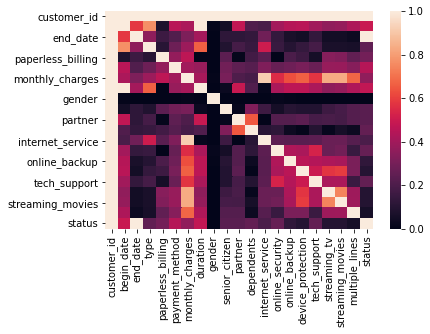

In [81]:
sns.heatmap(phik_overview)
plt.show()

In [82]:
numeric_data = ['monthly_charges', 'duration']

# 4. Feature Selection - отбор признаков для обучения моделей

In [83]:
df_total.head(3)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,duration,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,status
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31,Female,0,...,No,DSL,No,Yes,No,No,No,No,No,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1036,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,61,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,1


In [84]:
df_total.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'duration', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines', 'status'],
      dtype='object')

Удаляем признаки с датами и customer_id - они явно лишние 

In [85]:
df_total = df_total.drop(columns= ['customer_id','begin_date','end_date'], axis=1) 



Приводим категориальные даннные в количественные с помощью метода one hot encoding (OHE)

In [86]:
df_total.head()

,type,paperless_billing,payment_method,monthly_charges,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,status
0,Month-to-month,Yes,Electronic check,29.85,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0
1,One year,No,Mailed check,56.95,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0
2,Month-to-month,Yes,Mailed check,53.85,61,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1
3,One year,No,Bank transfer (automatic),42.30,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0
4,Month-to-month,Yes,Electronic check,70.70,61,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1


Определяем целевой признак и признаки для обучения модели 

In [87]:
features = df_total.drop(['status'], axis=1)
target = df_total['status']

Разбиваем данные на обучающую и тестовую выборки 

In [88]:
RANDOM_STATE = 281122 

In [89]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, 
                                                                              random_state = RANDOM_STATE, stratify=target)

Приводим категориальные даннные в количественные с помощью метода one hot encoding (OHE) для обучающей и тестовой выборок 

In [90]:
features_train = pd.get_dummies(features_train, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)

In [91]:
features_train.head(1)

,monthly_charges,duration,senior_citizen,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,...,dependents_Yes,internet_service_Fiber optic,internet_service_No,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes
4215,108.2,2191,0,0,1,1,0,1,0,1,...,0,1,0,0,1,1,1,1,1,1


In [92]:
features_test.head(1)

,monthly_charges,duration,senior_citizen,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,...,dependents_Yes,internet_service_Fiber optic,internet_service_No,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes
1558,95.6,487,0,0,0,1,1,0,0,0,...,0,1,0,0,1,1,0,0,1,1


Порядок столбцов на трейне и тесте совпадет 

Масштабируем количественные признаки на обучающей и тестовой выборках

In [93]:
scaler = StandardScaler()
scaler.fit(features_train[numeric_data])

StandardScaler()

In [94]:
features_train.copy()
features_train[numeric_data] = scaler.transform(features_train[numeric_data])



In [95]:
features_test = features_test.copy()
features_test[numeric_data] = scaler.transform(features_test[numeric_data])

Смотрим дисбаланс классов 

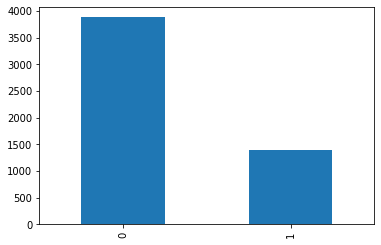

In [96]:
target_train.value_counts().plot(kind='bar')
plt.show()

Logistic Regression - обучение модели и получение результата на трейне с использованием метрики AUC-ROC 

In [97]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

model = LogisticRegression(solver='lbfgs', n_jobs=-1)

search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
search.fit(features_train, target_train)



best_params = str(search.best_params_)
best_score = search.best_score_
best_model = search.best_estimator_

best_score

0.8332038509766824

In [98]:
lr = search.best_estimator_.predict_proba(features_train)[:, 1]

In [99]:
print("AUC-ROC", roc_auc_score(target_train, lr))

AUC-ROC 0.8369451961115931


In [100]:
def plot_roc_curve(target_train, predictions):
    print('ROC-AUC score', roc_auc_score(target_train, predictions))
    
    fpr, tpr, thresholds = roc_curve(target_train, predictions)

    plt.figure(figsize=(11, 5))
    
    plt.plot(fpr, tpr)
    
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title('ROC-кривая')
    
    plt.show()

ROC-AUC score 0.8369451961115931


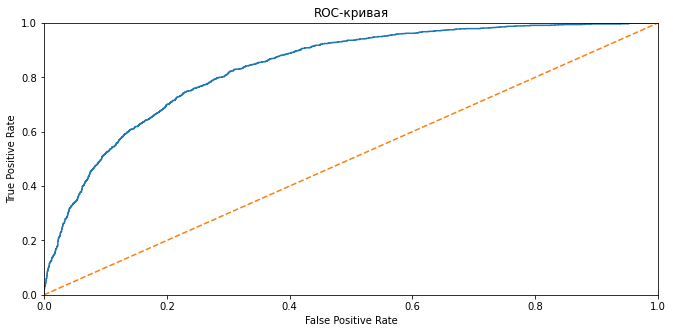

In [101]:
plot_roc_curve(target_train, lr)

<div class="alert alert-success">
<h2> Комментарий тимлида <a class="tocSkip"> </h2>

<b>Все отлично!👍</b> 

In [102]:
param_grid = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [2, 10],
    'n_estimators': [10, 50, 100], 
}

model = RandomForestClassifier(random_state=12345)

search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
search.fit(features_train, target_train)

best_params = str(search.best_params_)
best_score = search.best_score_
best_model = search.best_estimator_

best_score 


0.8491321020419396

In [103]:
RF = search.best_estimator_.predict_proba(features_train)[:, 1]

ROC-AUC score 0.8968905797314589


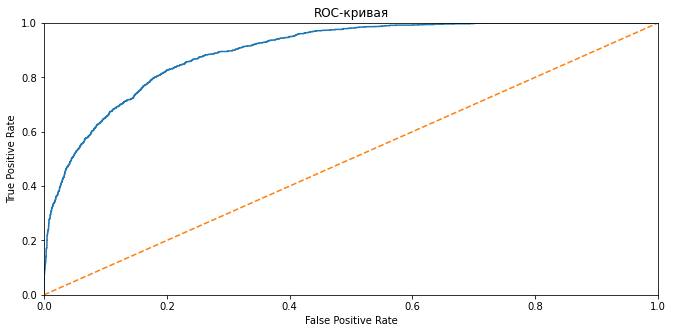

In [104]:
plot_roc_curve(target_train, RF)

CatBoostClassifier 

In [105]:
param_grid = {
    'learning_rate': [0.1, 0.3],
    'iterations': [50, 100],
    'l2_leaf_reg': [3, 9]
}

model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)

search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
search.fit(features_train, target_train)

best_params = str(search.best_params_)
best_score = search.best_score_
best_model = search.best_estimator_

best_score

0.9026328426773725

In [106]:
CB = search.best_estimator_.predict_proba(features_train)[:, 1]

ROC-AUC score 0.9756970895774814


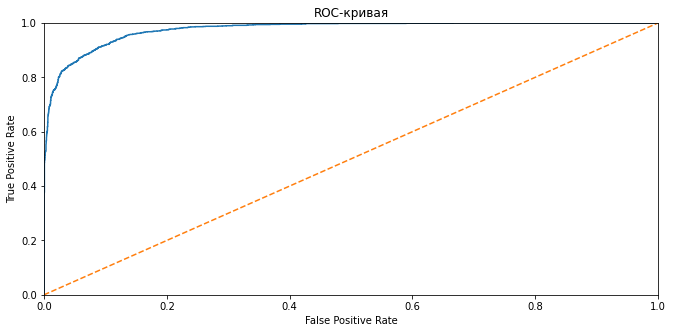

In [107]:
plot_roc_curve(target_train, CB)

Проверяем лучшую модель на тестовых данных

In [108]:
CB = search.best_estimator_.predict_proba(features_test)[:, 1]

ROC-AUC score 0.9332390641703265


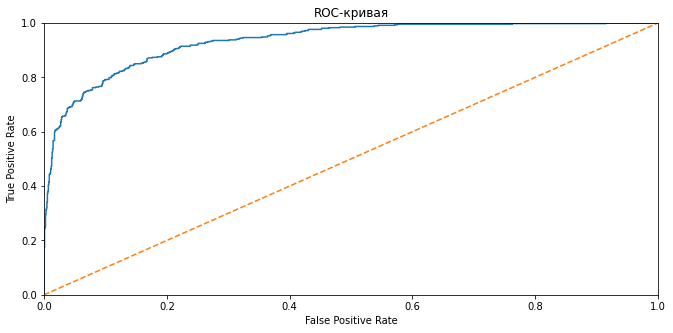

In [109]:
plot_roc_curve(target_test, CB)

Сводный анализ моделей и итоговый вывод: 

In [110]:
index=['Logistic Regression', 'Random Forest', 'CatBoost Classifier'] 
data ={'ROC-AUC score_train': [0.84, 0.89, 0.97], 'ROC-AUC score_test':['no_test','no_test', 0.93 ]  }

scores_data = pd.DataFrame(data=data, index=index)
display(scores_data)

,ROC-AUC score_train,ROC-AUC score_test
Logistic Regression,0.84,no_test
Random Forest,0.89,no_test
CatBoost Classifier,0.97,0.93


Анализ важности факторов:

In [111]:
importances_df = pd.DataFrame(search.best_estimator_.feature_importances_, 
                              index = features_test.columns, columns=['importances'])
importances_df = importances_df.sort_values(by='importances', ascending=False)
importances_df

,importances
duration,53.892576
monthly_charges,12.304292
type_Two year,4.312251
internet_service_Fiber optic,4.051460
type_One year,3.580440
payment_method_Electronic check,2.561199
streaming_movies_Yes,1.943471
paperless_billing_Yes,1.915361
senior_citizen,1.889483
tech_support_Yes,1.813926


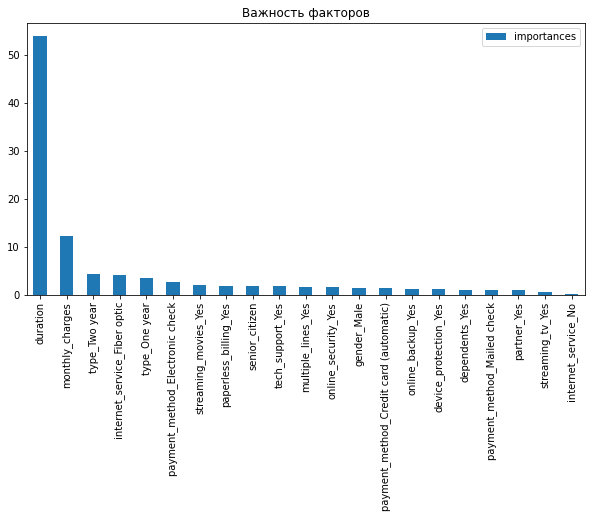

In [112]:
importances_df.plot(kind='bar', figsize=(10, 5), title='Важность факторов')
plt.show()

Важные факторы для модели: duration- количество дней в компании, а также monthly_charges размер месячного платежа.

Итоговый вывод:

   - Основными задачами проекта было изучение данных по оттоку клиентов телеком компании, понимание причин, поиск зависимости между данными и поведением клиентов, а также создание модели машинного обучения для предсказания потенциально возможных клиентов, которые могут уйти из компании
   - Данные прошли предобработку на этапе которой были переименованы столбцы, изменен тип данных, устранены отсутствующие значения, обработаны аномалии и сделаны первые выводы
   - Далее был введен целевой признак - status, который отражает текущий статус клиента: 1-клиент ушел, 0- активный клиент
   - Был введен дополнительный признак - duration, период получения денежный потоков компанией от клиента: сколько дней клиент с компанией
   - Был проведен анализ распределения данных, выявлены зависимости, которые представлены в виде сводных таблиц по наиболее значимым признакам. Сделано заключение по закономерностям и причинам ухода клиентов из компании: от услуг отказываются в первый год договора при росте месячного платежа выше порогового значения, со временем вероятность ухода клиента из компании снижается  
   - Далее была проведена подготовка данных для последующего машинного обучения. Лишние не информативные столбцы были удалены, а остальные прошли процесс масштабирования и кодирования. Также была произведена балансировка классов.
   - Были обучены три модели машинного обучения: Logistic Regression, Randon Forest и модель градиентного бустинга CatBoost Regressor. 
   - Все модели показали достойную метрику оценки AUC-ROC - основная метрика оценки предсказания бинарной классификации
   - Лучший результат показала модель градиентного бустинга CatBoost Rgressor -0.91.
   - В итоге мы получили модель которая с вероятностью выше 90% сможет предсказать уход клиента из компании 
   
   
   

# Отчет по проекту: 

##  Вступление:



   Задание проекта - создание для оператор связи «Ниединогоразрыва.ком» модели машинного обучения для прогнозирования оттока клиентов по      информации внутренней базы данных, которая была представлена командой оператора. Если выяснится, что пользователь планирует уйти, ему будут    предложены промокоды и специальные условия. Работа выполнена на языке Python, c использваонием основных библиотек Pandas, Numpy,   
    Seaborn, Matplotlib  и основной библиотеки машинного обучения Sklearn   

## Обработка данных:


   
   Были получены четыре файла с информацией по условиям предоставляемых услуг для каждого клиента: даты открытия и расторжения   
   договора, тарифа, форма оплаты, а также пакет подключенных дополнительных интернет услугах и телефонии для каждого клиента. 
   Персональные данные также представлены в отдельном файле.
   
   Данные прошли предобработку: были заменены название столбцов, изменен тип данных некоторых признаков, отсутсвующие значения были       корректно заполнены. На выходе была получена одна сводная таблица с полной информацией по каждому клиенту нобходимой для дальнейшего      исследования. 

## Исследовательский анализ EDA:


   
   Для проведения EDA (Exploratory Data Analysis) данные были классифицированы в количественные и качественный признаки.    
   Дополнительно был создан важный признак по дюрации денежных потоков от каждого клиента. Выявлены зависимости между данными и 
   целевым признаком - уходом клиента из компании. Наиболее сильная зависимость найдена между признаками длительность договора, размер 
   месячного платежа клиента и целевым признаком - фактом уходом клиента из компании. 
   
   Общий вывод: Компанию покинуло 26% клиентов. Из низ примерно в равной пропорции мужчины и женщины, клиенты использовали в   
   большинстве своем по месячную оплату услуг, а также электронную форму оплаты. То есть в основном уходили те кто использует 
   помесячную форму оплаты.

   Главный вывод - это факт ухода из компании большого количества клиентов в первый год обслуживания в случае роста размера месячного 
   платежа. Также интересна обратная зависимость, чем дольше клиент в компании тем ниже вероятность, что он расторгнет договор и уйдет из 
   компании. Возможно имеет смысл обратить внимание на пороговое значение месячного тарифа уровня значения третьего квантиля распределения 
   (60-80 единиц). Достижение данного уровня является сигналом для лояльных действий со стороны Компании по отношению к Клиенту особенно 
   после первого года обслуживани, в противном случае вероятность ухода клиента будет возрастать.
  

## Подготовка данных к машинному обучению:

Для обучения моделей машинного обучения были использованы следующие признаки:
       'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'duration', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'.
       
Цель обучения - научить модель предсказывать целевой признак 'status', данные которого имеют бинарную классификацию (1- клиент ушел из компании, 0 -клиент активен).
    Данные были разбиты на обучающую выборку для обучения моделей и тестовую для проверки точности предсказания лучшей модели. 
    Далее было произведено масштабирование непрерывных признаков и кодирование количественных.  


Для сравнительного анализа были выбраны модели машиннного обучения: Логистическая регрессия (LogisticRegression), Случайный лес (RandomForest) и модель градиентного бустинга CatBoost Clasifier. Для определения точности работы каждой модели была выбрана метрика ROC-AUC, которая отображает соотношение между долей объектов от общего количества носителей признака, верно классифицированных и долей объектов от общего количества объектов, которые были ошибочно классифицированны. Модели были обучены с кроссвалидацией и подбором гиперпараметров на трейн выборке. 

По итогам проверки модели показали следующее значение метрики ROC-AUC:


In [113]:
index=['Logistic Regression', 'Random Forest', 'CatBoost Classifier'] 
data ={'ROC-AUC score_train': [0.84, 0.89, 0.97], 'ROC-AUC score_test':['no_test','no_test', 0.93 ]  }

scores_data = pd.DataFrame(data=data, index=index)
display(scores_data)

,ROC-AUC score_train,ROC-AUC score_test
Logistic Regression,0.84,no_test
Random Forest,0.89,no_test
CatBoost Classifier,0.97,0.93


Модель CatBoost Classifier показала лушую метрику на обучающей выборке - 0.97. Полученный результат на тестовой выборке - 0.93 (на новых можно сказать абсолютно "незнакомых данных")  подтверждает высокое качество работы данной модели.

## Анализ важности факторов 


Ниже представлена сводная информация по важности признаков по данным нашего исследования:

In [114]:
importances_df = pd.DataFrame(search.best_estimator_.feature_importances_, 
                              index = features_test.columns, columns=['importances'])
importances_df = importances_df.sort_values(by='importances', ascending=False)
importances_df

,importances
duration,53.892576
monthly_charges,12.304292
type_Two year,4.312251
internet_service_Fiber optic,4.051460
type_One year,3.580440
payment_method_Electronic check,2.561199
streaming_movies_Yes,1.943471
paperless_billing_Yes,1.915361
senior_citizen,1.889483
tech_support_Yes,1.813926


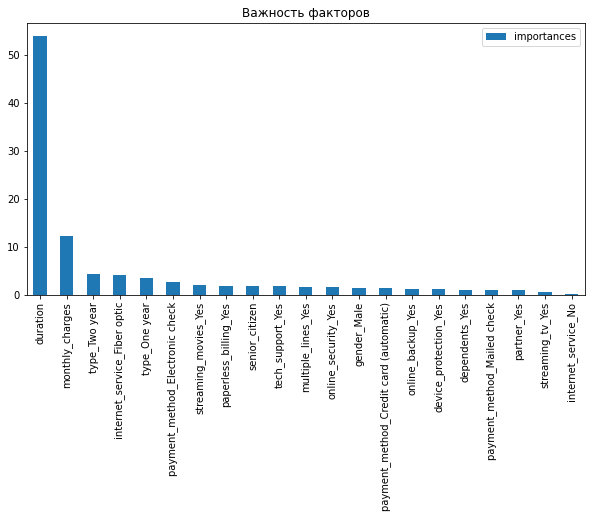

In [115]:
importances_df.plot(kind='bar', figsize=(10, 5), title='Важность факторов')
plt.show()

Самые важные факторы влияющию на уход клиента: 
  - duration - общий срок обслуживания клиента в компании
  - monthly_charges размер месячного платежа 
  - тип договора (на какой срок заключен договор )

## Выполнение Плана 

В первом блоке был составлен План по выполнению задания, который был сделан по итогам первого раздела - "Изучение данных" и которого мы придерживались в ходе выполнения всего проекта. Необходимо отметить, что на этапе подготовки данных к машинному обучению мы столкнулись с трудностями в части подготовки данных для правильного обучения моделей. Точнее это были не трудности, а скорей варианты решения, понимание о правильности которых пришло в ходе анализа данных и подборе правильного метода для решения. В нашем случае в ходе подготовки данных к обучению моделей была допушена неточность в порядке выполнения кодирования для качественых признаков, что могло бы привести к утечке данных, ухудшению метрики и усложнению процесса в будущем при возможной обработки новых данных в дальнейших исследований. В итоге кодирование было проведено с помощью метода get dummies после разбиение на тренировочную и тестовую выборки. Также было возможно использование метода OneHotEncoder через pipeline, который был бы интегрирован в GridSearch и таким образом кодирование данных и подбор оптимальных гиперпараметров было бы замнкнуто в единый контур, что в принципе упрощает работу всей модели и делает ее более универсальной для работы в будущем. Но в нашем случае вариант, который мы применили оказался достаточным - полученная метрика по всем моделям оказалась сравнительно высокой.

## Заключение 

Создана модель машинного обучения, которая по аналогичному формату данных сможет предсказывать уход клиентов из Телеком компании «Ниединогоразрыва.ком». Найдены зависимости в данных. Выводы в работе дают полное понимания того, что неободимо делать, чтобы клиенты не уходили из компании, а также дают сигналы для возможных лояльных действий по отношению к определенной группе клиентов в случае роста вероятности их ухода из Компании. Полученный результат, проведенные исследования и выводы полностью отвечают на вопросы которые мы получили в задании. 
